In [1]:
import pennylane as qml
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from pennylane import numpy as np
import math

import matplotlib.pyplot as plt
from scipy.integrate import quad
from sklearn.model_selection import train_test_split


In [2]:
E0 = 0
Gamma = 2.5

In [3]:
def breit_wigner(E, E0, Gamma):
    """
    Calculates the value of the Breit-Wigner distribution for a given energy.

    Parameters:
    - E: The energy at which to evaluate the distribution.
    - E0: The resonance energy, or the peak position of the distribution.
    - Gamma: The width of the resonance.

    Returns:
    - The value of the Breit-Wigner distribution at energy E.
    """
    return 1 / ((E - E0)**2 + (Gamma / 2)**2)


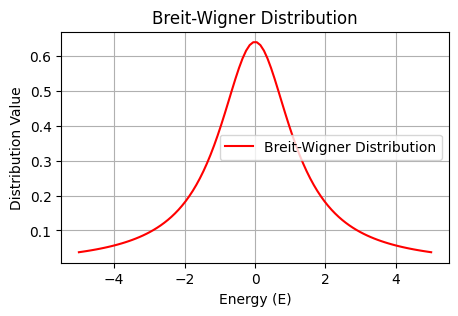

In [4]:
E_values_plot = np.linspace(-5, 5, 100)
BW_values = [breit_wigner(E, E0, Gamma) for E in E_values_plot]

# 분포 플롯
plt.figure(figsize=(5, 3))
plt.plot(E_values_plot, BW_values, label='Breit-Wigner Distribution', color='red')
plt.xlabel('Energy (E)')
plt.ylabel('Distribution Value')
plt.title('Breit-Wigner Distribution')
plt.legend()
plt.grid(True)
plt.show()


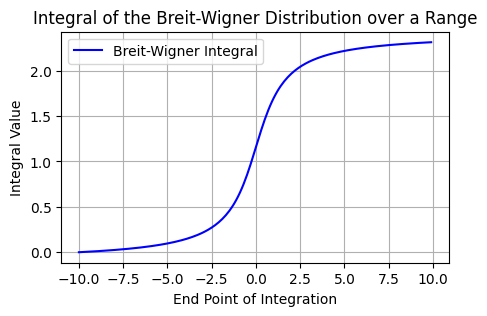

In [5]:
import matplotlib.pyplot as plt

# 특정 구간에서 브라이트위그너 함수의 적분값을 계산하는 함수
def integrate_breit_wigner(E0, Gamma, start, end):
    integral, _ = quad(breit_wigner, start, end, args=(E0, Gamma))
    return integral

# 계산할 구간 설정 (-10부터 10까지, 0.1 간격)
E_values = np.arange(-10, 10, 0.1)
integral_values = [integrate_breit_wigner(E0, Gamma, -10, E) for E in E_values]

# 결과 플롯
plt.figure(figsize=(5,3))
plt.plot(E_values, integral_values, label='Breit-Wigner Integral', color='blue')
plt.xlabel('End Point of Integration')
plt.ylabel('Integral Value')
plt.title('Integral of the Breit-Wigner Distribution over a Range')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
Ndata = 1000
E_values_plot = np.linspace(-5, 5, Ndata)
BW_values = [breit_wigner(E, E0, Gamma) for E in E_values_plot]


In [7]:
Xdata = np.array(E_values_plot, requires_grad=False).reshape(Ndata, 1)
ydata = np.array(BW_values, requires_grad=False)

[0.79440072 0.76481999 0.95420472 0.4703717  0.31044003 0.03466316
 0.61778638 0.10276482 0.87711457 0.82681404 0.66584376 0.78109875
 0.97867365 0.01657496 0.85309974 0.3658837  0.03114448 0.13566124
 0.19869155 0.56455453]
1
------------------------------------------------------------------
-0.07132933937885871
------------------------------------------------------------------


/home/kban/.local/lib/python3.8/site-packages/pennylane_lightning/lightning_qubit/lightning_qubit.py:822: UserWarning: Pre-compiled binaries for lightning.qubit are not available. Falling back to using the Python-based default.qubit implementation. To manually compile from source, follow the instructions at https://pennylane-lightning.readthedocs.io/en/latest/installation.html.
  warn(


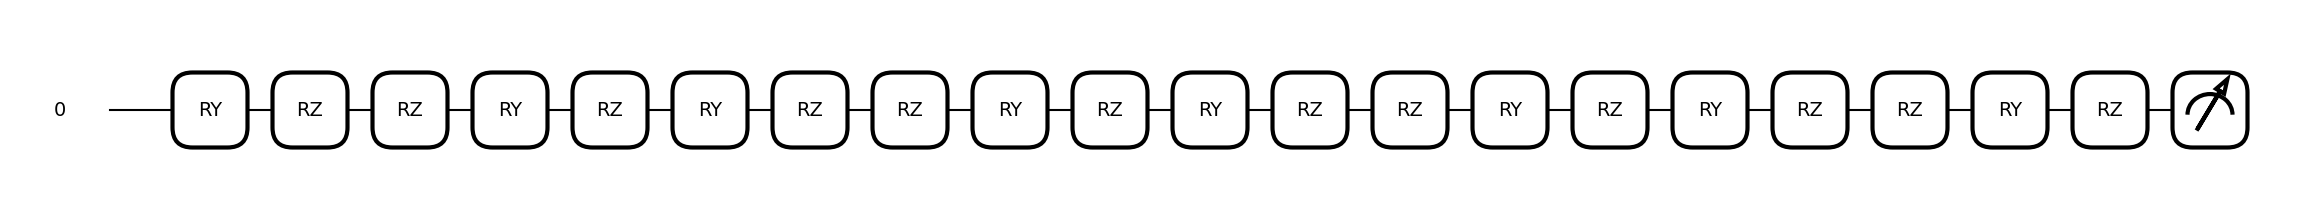

In [8]:
dev = qml.device("lightning.qubit", wires = 10)

@qml.qnode(dev)
def VQC_Model(thetas, phis, x, num_layers):
    """
    Variational Quantum Circuit model for Multi Variable Integration

    INPUT
    params : parameters for the circuit we will train them
    phis : array of parameters applied to the last RY gate
    x(Xdata[i]) : data point we have to upload
    num_layers : layers for the circuit

    OUTPUT
    Expectation value with PauliZ measure
    """
    
    dim = len(x)
    # dim = 1
    num_qubits = math.ceil(dim / 2)
    idx = 0

    params = list(thetas).copy()
    
    for _ in range(num_layers):
        for i in range(dim):
            qubit = i // 2
            qml.RY(params[idx], wires = qubit)
            qml.RZ(params[idx+1]*x[i], wires = qubit, id = f'x{i}') # Re-uploading data here
            qml.RZ(params[idx+2], wires = qubit)
            qml.RY(params[idx+3], wires = qubit)
            qml.RZ(params[idx+4], wires = qubit)
            idx += 5

        if num_qubits > 1:
            for q in range(0,num_qubits-1,1):
                qml.CZ([q, q+1])
            if num_qubits > 2:
                qml.CZ([num_qubits-1, 0])

    if num_qubits > 1:
        for i in range(num_qubits):
           qml.RY(phis[i], wires=i, id = f"phi{i}")
    
    obs = qml.PauliZ(0)
    for i in range(num_qubits-1):
         obs = obs @ qml.PauliZ(i+1)

    return qml.expval(obs)

# ------------------------------------------------------------------ #
x = Xdata[0]
dim = len(x)
num_layers = 4
num_qubits = math.ceil(len(x) / 2)

thetas = np.random.uniform(size = dim*num_layers*5,requires_grad = True)
phis = np.random.uniform(size = num_qubits, requires_grad =True)


print(thetas)
print(len(x))
print('------------------------------------------------------------------')
print(VQC_Model(thetas, phis, x, num_layers))
print('------------------------------------------------------------------')
fig, ax = qml.draw_mpl(VQC_Model)(thetas, phis, x, num_layers)


In [9]:
def cost_function(thetas, phis, Xdata, num_layers, y):
    loss = 0.0

    for i in range(len(Xdata)):
        prediction = VQC_Model(thetas, phis, Xdata[i], num_layers)
        loss += (prediction - y[i])**2

    return loss / len(Xdata)

# ------------------------------------------------------------------ #

#Xdata, ydata = Cos(100, [1, 2, 1/2], 3, xmax=[np.pi, np.pi, np.pi], xmin = [0, 0, 0])
#x = Xdata[:20]
#dim = len(x)
#num_layers = 2
#num_qubits = math.ceil(len(x) / 2)

#thetas = np.random.uniform(size = dim*num_layers*5,requires_grad = True)
#phis = np.random.uniform(size = num_qubits, requires_grad =True)

#cost_function(thetas, phis, x, num_layers, ydata)


### Model Running

In [10]:
def model_running(thetas, phis, x, num_layers):
    """
    Model running with given set of data.

    INPUT


    Returns
    Predicted labels for given data, Expectation value of the circuit
    """
    
    exepctation_values = []

    for i in range(len(x)):
        expval = VQC_Model(thetas, phis, x[i], num_layers)
        exepctation_values.append(expval)
        
    return np.array(exepctation_values)

In [11]:
def accuracy(ypred, ydata):

    ratio = []
    score = 0
    for i in range(len(ydata)):
        acc = ypred[i] / ydata[i] - 1
        if np.abs(acc) < 0.2:
            score += 1
        ratio.append(ypred[i] / ydata[i])

    return ratio, score/len(ydata)

In [12]:
def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data
    
    INPUT
    inputs : input data
    targets : targets
    batch_size : size of the batch, the number of datas in one batch

    Returns
    one batch of input data of length `batch_size`, one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

-------------

In [13]:
### Preparing datas
train_data, val_data, train_target, val_target = train_test_split(Xdata, ydata, test_size=0.2, random_state=42)
train_target = train_target.reshape(-1)
val_target = val_target.reshape(-1)

# for making cos(x*a + a0)
x = train_data[0]
dim = len(x)

# Trainnig option settings
num_layers = 4
epochs = 100
batch_size = 50
lr = 0.001

# Using the Optimizer
opt = AdamOptimizer(lr)                 ### Adam Optimizer
#opt = GradientDescentOptimizer(lr)      ### GradientDescent based on Parmaeter Shift Rule

# Initializing random parameters for the circuit
thetas = np.random.uniform(size=dim*num_layers*5, requires_grad=True)
phis = np.random.uniform(size = num_qubits, requires_grad =True)

### Evaluating the qNN
# Running the model with val data
pred_train = model_running(thetas, phis, train_data, num_layers)
ratio_train, score_train = accuracy(pred_train, train_target)

# Running the model with the val data
pred_val = model_running(thetas, phis, val_data, num_layers)
ratio_val, score_val = accuracy(pred_val, val_target)

# Saving predictions with random weights for comparison 
initial_predictions = pred_val

loss = cost_function(thetas, phis, val_data, num_layers, val_target)

loss_list = [loss]
accuracy_train_list = [score_train]
accuracy_val_list = [score_val]

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Val Accuracy: {:3f}".format(
        0, loss.item(), score_train, score_val
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(train_data, train_target, batch_size=batch_size):
        thetas, phis, _, _, _ = opt.step(cost_function, thetas, phis, Xbatch, num_layers, ybatch)

    pred_train = model_running(thetas, phis, train_data, num_layers)
    ratio_train, score_train = accuracy(pred_train, train_target)
    loss = cost_function(thetas, phis, train_data, num_layers, train_target)

    pred_val = model_running(thetas, phis, val_data, num_layers)
    ratio_val, score_val = accuracy(pred_val, val_target)
    res = [it + 1, loss.item(), score_train, score_val]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Val accuracy: {:3f}".format(
            *res
        )
    )

    loss_list.append(loss)
    accuracy_train_list.append(score_train)
    accuracy_val_list.append(score_val)


Epoch:  0 | Cost: 0.420750 | Train accuracy: 0.020000 | Val Accuracy: 0.025000
Epoch:  1 | Loss: 0.444913 | Train accuracy: 0.022500 | Val accuracy: 0.025000
Epoch:  2 | Loss: 0.396004 | Train accuracy: 0.020000 | Val accuracy: 0.040000
Epoch:  3 | Loss: 0.351872 | Train accuracy: 0.020000 | Val accuracy: 0.050000
Epoch:  4 | Loss: 0.311567 | Train accuracy: 0.023750 | Val accuracy: 0.045000
Epoch:  5 | Loss: 0.273167 | Train accuracy: 0.050000 | Val accuracy: 0.055000
Epoch:  6 | Loss: 0.235761 | Train accuracy: 0.045000 | Val accuracy: 0.040000
Epoch:  7 | Loss: 0.199693 | Train accuracy: 0.042500 | Val accuracy: 0.050000
Epoch:  8 | Loss: 0.165733 | Train accuracy: 0.097500 | Val accuracy: 0.075000
Epoch:  9 | Loss: 0.134661 | Train accuracy: 0.092500 | Val accuracy: 0.090000
Epoch: 10 | Loss: 0.107282 | Train accuracy: 0.101250 | Val accuracy: 0.080000
Epoch: 11 | Loss: 0.084431 | Train accuracy: 0.090000 | Val accuracy: 0.085000
Epoch: 12 | Loss: 0.066694 | Train accuracy: 0.09125

In [14]:
print("Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Val accuracy: {:3f}".format( *res) )

Epoch: 100 | Loss: 0.000262 | Train accuracy: 0.797500 | Val accuracy: 0.810000


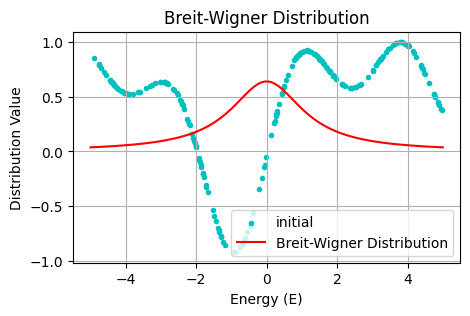

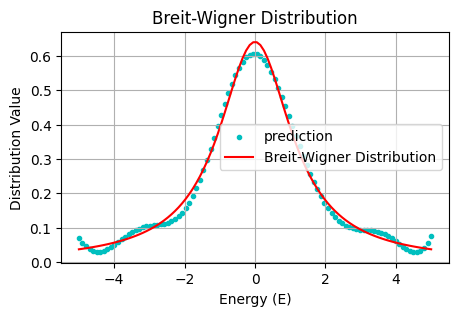

In [15]:
E_values_plot = np.linspace(-5, 5, 100)
BW_values = [breit_wigner(E, E0, Gamma) for E in E_values_plot]

Xtest = np.array(E_values_plot, requires_grad=False).reshape(100, 1)
ytest = np.array(BW_values, requires_grad=False)

pred_test = model_running(thetas, phis, Xtest, num_layers)

# 분포 플롯
plt.figure(figsize=(5, 3))
plt.scatter(val_data, initial_predictions, label='initial', color='c', marker='.')
plt.plot(Xtest, ytest, label='Breit-Wigner Distribution', color='red')
plt.xlabel('Energy (E)')
plt.ylabel('Distribution Value')
plt.title('Breit-Wigner Distribution')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(5, 3))
plt.scatter(Xtest, pred_test, label='prediction', color='c', marker='.')
plt.plot(Xtest, ytest, label='Breit-Wigner Distribution', color='red')
plt.xlabel('Energy (E)')
plt.ylabel('Distribution Value')
plt.title('Breit-Wigner Distribution')
plt.legend()
plt.grid(True)
plt.show()
